In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf

sns.set_style('darkgrid')

In [14]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    It uses Locally Weighted Scatterplot Smoothing (LOWESS) to fit a model. 
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    pred = model.fittedvalues
    influence = model.get_influence()
    resid_std = influence.resid_studentized_internal
    
    fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
    
    sns.regplot(x=pred, y=y, lowess=True, ax=ax[0], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=yhat) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[min(pred), max(pred)], 
                 ax=ax[0], color='red', ls=':')
    ax[0].set_title('Observed vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Observed')
    
    sns.regplot(x=pred, y=resid_std, lowess=True, ax=ax[1], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Residuals vs. Predicted Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Standardized Residual')
    
    return fig, ax

In [15]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan 
    and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    import statsmodels.stats.api as sms
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    pred = model.fittedvalues
    resid = model.resid
    resid_z = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2, figsize=(12,5.5))

    sns.regplot(x=pred, y=resid, lowess=True, ax=ax[0], line_kws={'color': 'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[0], color='red', ls=':')
    ax[0].set_title('Residuals vs. Fitted Values')
    ax[0].set(xlabel='Fitted', ylabel='Residual')

    sns.regplot(x=pred, y=np.sqrt(np.abs(resid_z)), lowess=True, ax=ax[1], line_kws={'color': 'darkorchid'})
    # I've added the ideal line for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0.822,0.822], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Scale-Location')
    ax[1].set(xlabel='Fitted', ylabel=r'$\sqrt{|{\mathrm{Standardized~Residual}}|}$')

    # Breusch-Pagan tests if regression on 'Residuals ~ Fitted Values' has non-zero slope
    # Good for picking up trends of strictly increasing or decreasing variance
    bp_test = pd.DataFrame(sms.het_breuschpagan(resid, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    # Goldfeld-Quandt tests if variance on left half of residual plot is equal to variance on right half
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resid, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')
    plt.show()

In [31]:
def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 5 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    import scipy.stats as stats
    import statsmodels.graphics.api as smg
    import statsmodels.stats.api as sms
    
    fig, ax = plt.subplots(figsize=(6,5))
    smg.qqplot(data=model.resid, line='45', fit=True, ax=ax);
    ax.set_title('Q-Q plot');
    resid_z = model.get_influence().resid_studentized_internal

    sw = stats.shapiro(model.resid)
    dp = stats.normaltest(model.resid)
    jb = stats.jarque_bera(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    lf = sms.lilliefors(model.resid)
    ks = stats.kstest(resid_z, 'norm')
    
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f"D'Agostino-Pearson Omnibus test ---- statistic: {dp[0]:.4f}, p-value: {dp[1]:.4f}")
    print(f'Lilliefors test ---- statistic: {lf[0]:.4f}, p-value: {lf[1]:.4f}')
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, '\
          'the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
    plt.show()

In [17]:
def autocorrelation_plot(model):
    import statsmodels.tsa.api as smt
    fig, ax = plt.subplots(figsize=(12,6))
    acf = smt.graphics.plot_acf(model.resid, lags=40, alpha=0.05, ax=ax)

# Boston Housing

In [18]:
from sklearn.datasets import load_boston
boston=load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
X.drop('CHAS', axis=1, inplace=True)
y = pd.Series(boston.target, name='MEDV')

In [19]:
model = smf.ols('MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT', X.join(y)).fit()

In [20]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.729    
Dependent Variable: MEDV             AIC:                3033.5121
Date:               2022-11-28 15:35 BIC:                3088.4570
No. Observations:   506              Log-Likelihood:     -1503.8  
Df Model:           12               F-statistic:        114.3    
Df Residuals:       493              Prob (F-statistic): 7.30e-134
R-squared:          0.736            Scale:              22.916   
-------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|    [0.025    0.975]
-------------------------------------------------------------------
Intercept    36.8920    5.1465    7.1683  0.0000   26.7801  47.0038
CRIM         -0.1131    0.0331   -3.4168  0.0007   -0.1782  -0.0481
ZN            0.0471    0.0138    3.3981  0.0007    0.0198   0.0743
INDUS         0.0403    0.0617    0.6533  0.5139   -0.0809   0.1616
NOX         -17.3670    3.8512   -4.5095  0.0000  -24.9338  -9.8002
RM            3.8505    0.4214    9.1373  0.0000    3.0225   4.6785
AGE           0.0028    0.0133    0.2092  0.8344   -0.0234   0.0289
DIS          -1.4854    0.2012   -7.3831  0.0000   -1.8807  -1.0901
RAD           0.3283    0.0665    4.9339  0.0000    0.1976   0.4591
TAX          -0.0138    0.0038   -3.6529  0.0003   -0.0212  -0.0064
PTRATIO      -0.9910    0.1314   -7.5416  0.0000   -1.2491  -0.7328
B             0.0097    0.0027    3.5999  0.0004    0.0044   0.0151
LSTAT        -0.5342    0.0511  -10.4590  0.0000   -0.6345  -0.4338
------------------------------------------------------------------
Omnibus:             190.856       Durbin-Watson:          1.016  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       898.352
Skew:                1.619         Prob(JB):               0.000  
Kurtosis:            8.668         Condition No.:          15113  
==================================================================
* The condition number is large (2e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [21]:
model.mse_resid

22.916338610821434

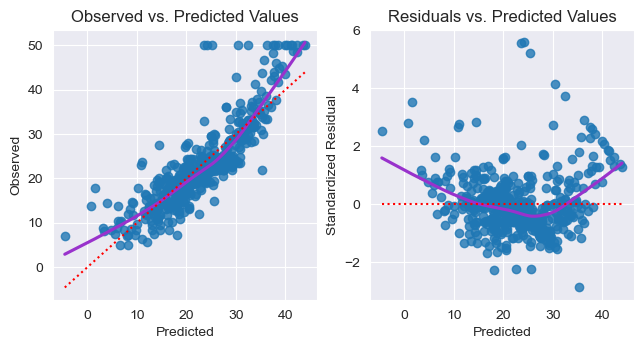

In [30]:
fig, ax = linearity_test(model,y)
plt.show()


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  6.028613e+01
p-value                        2.001794e-08
f-value                        5.556828e+00
f p-value                      5.935449e-09

 Goldfeld-Quandt test ----
                    value
F statistic  2.620956e+00
p-value      1.251137e-13

 Residuals plots ----


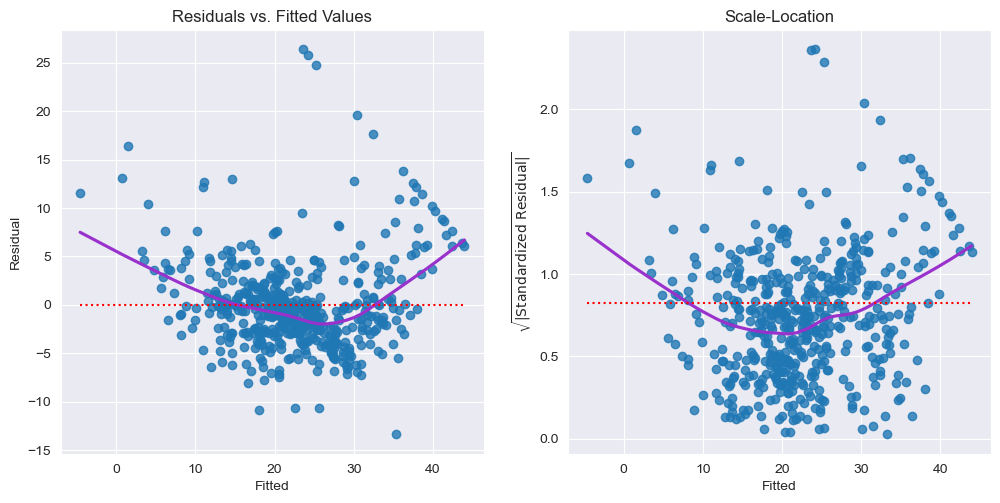

In [23]:
homoscedasticity_test(model)

Shapiro-Wilk test ---- statistic: 0.8953, p-value: 0.0000
D'Agostino-Pearson Omnibus test ---- statistic: 190.8560, p-value: 0.0000
Lilliefors test ---- statistic: 0.1246, p-value: 0.0010
Jarque-Bera test ---- statistic: 898.3521, p-value: 0.0
Kolmogorov-Smirnov test ---- statistic: 0.1249, p-value: 0.0000
Anderson-Darling test ---- statistic: 10.9109, 5% critical value: 0.7810
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


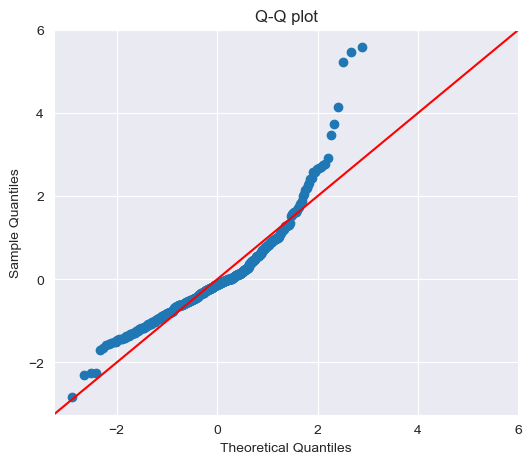

In [32]:
normality_of_residuals_test(model)

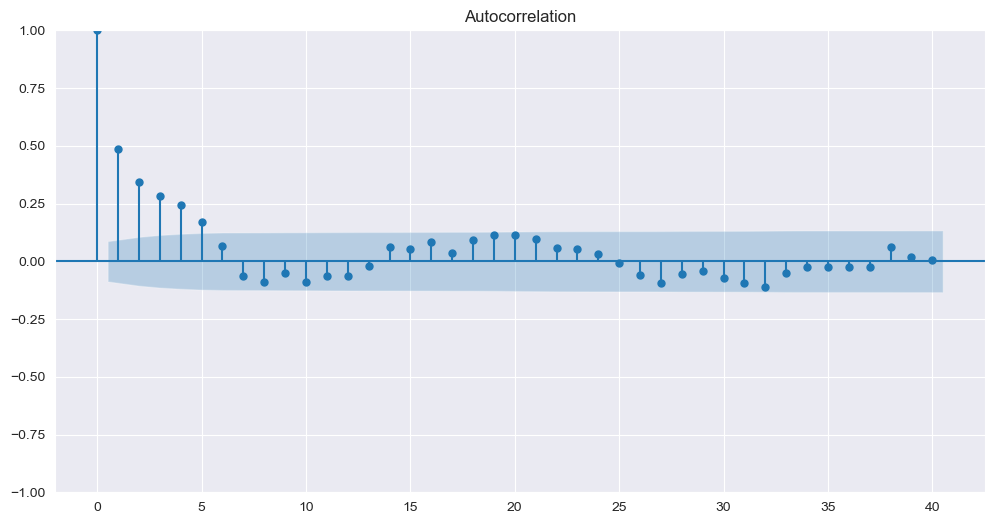

In [25]:
autocorrelation_plot(model)

This indicates there is some information in the index that is not captured in our model. In many cases the index is the order that data was collected, so this would indicate the need for a time-series model. Here, it is likely geographically sorted in some way that causes this.

In [26]:
# Durbin-Watson is a number between 0 and 4. <2 is positive correlation. >2 is negative correltion.
# As a rule of thumb, anything between 1.5 and 2.5 is OK
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.729    
Dependent Variable: MEDV             AIC:                3033.5121
Date:               2022-11-28 15:35 BIC:                3088.4570
No. Observations:   506              Log-Likelihood:     -1503.8  
Df Model:           12               F-statistic:        114.3    
Df Residuals:       493              Prob (F-statistic): 7.30e-134
R-squared:          0.736            Scale:              22.916   
-------------------------------------------------------------------
             Coef.    Std.Err.     t      P>|t|    [0.025    0.975]
-------------------------------------------------------------------
Intercept    36.8920    5.1465    7.1683  0.0000   26.7801  47.0038
CRIM         -0.1131    0.0331   -3.4168  0.0007   -0.1782  -0.0481
ZN            0.0471    0.0138    3.3981  0.0007    0.0198   0.0743
INDUS         0.0403    0.0617    0.6533  0.5139   -0.0809   0.1616
NOX         -17.3670    3.8512   -4.5095  0.0000  -24.9338  -9.8002
RM            3.8505    0.4214    9.1373  0.0000    3.0225   4.6785
AGE           0.0028    0.0133    0.2092  0.8344   -0.0234   0.0289
DIS          -1.4854    0.2012   -7.3831  0.0000   -1.8807  -1.0901
RAD           0.3283    0.0665    4.9339  0.0000    0.1976   0.4591
TAX          -0.0138    0.0038   -3.6529  0.0003   -0.0212  -0.0064
PTRATIO      -0.9910    0.1314   -7.5416  0.0000   -1.2491  -0.7328
B             0.0097    0.0027    3.5999  0.0004    0.0044   0.0151
LSTAT        -0.5342    0.0511  -10.4590  0.0000   -0.6345  -0.4338
------------------------------------------------------------------
Omnibus:             190.856       Durbin-Watson:          1.016  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       898.352
Skew:                1.619         Prob(JB):               0.000  
Kurtosis:            8.668         Condition No.:          15113  
==================================================================
* The condition number is large (2e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [27]:
sms.durbin_watson(model.resid)

1.0158717290433874

### And let's take a moment to think about ethics

In [28]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Some of the assumptions made by the original paper:
LSTAT: “Proportion of population that is lower status = 0.5 * (proportion of adults without some high school education and proportion of male workers classified as laborers). The logarithmic specification implies that socioeconomic status distinctions mean more in the upper brackets of society than in the lower classes.”

B: “Proportion of population that is Black. At low to moderate levels of B, an increase in B should have a negative influence on housing value if Black people are regarded as undesirable neighbors by White people. However, market discrimination means that housing values are higher at very high levels of B. One expects, therefore, a parabolic relationship between proportion Black in a neighborhood and housing values.”

<AxesSubplot:xlabel='B', ylabel='MEDV'>

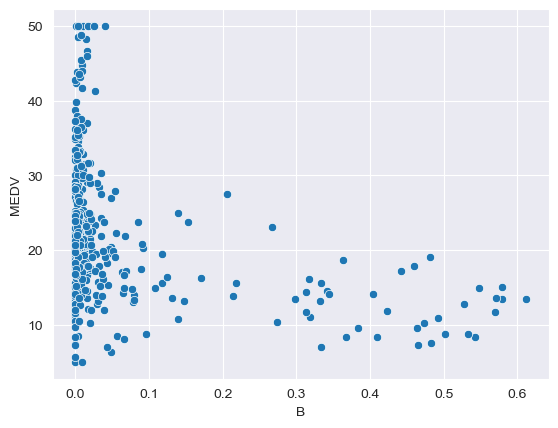

In [29]:
sns.scatterplot(x=X['B'].apply(lambda xx: 0.63 - np.sqrt(xx/1000)),y=y)

https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8

https://fairlearn.org/main/user_guide/datasets/boston_housing_data.html

https://scikit-fairness.readthedocs.io/en/latest/fairness_boston_housing.html